# Income Factors

## Imports and Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from copy import copy
from warnings import simplefilter
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
simplefilter(action='ignore', category=FutureWarning)
sns.set() 

# Data Preperation and Clean-up

## Loading Data

In [2]:
# load data and get head
census_df = pd.read_csv('census.csv')
census_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## EDA and Data Clean-up

### Review Datatypes and Appropriate Values (Categorical vs. Numerical)

In [3]:
#get and print shape
print(census_df.shape)

(48842, 15)


In [4]:
#get and print datatypes for each variable
print(census_df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


In [5]:
# This is to check out all of the categories in the columns
categorical = [col for col in census_df.columns if type(census_df[col][0])==str]
domains = [set(census_df[i]) for i in categorical]
pp.pprint(dict(zip(categorical, domains)))

{'education': {'10th',
               '11th',
               '12th',
               '1st-4th',
               '5th-6th',
               '7th-8th',
               '9th',
               'Assoc-acdm',
               'Assoc-voc',
               'Bachelors',
               'Doctorate',
               'HS-grad',
               'Masters',
               'Preschool',
               'Prof-school',
               'Some-college'},
 'income': {'>50K', '<=50K'},
 'marital-status': {'Divorced',
                    'Married-AF-spouse',
                    'Married-civ-spouse',
                    'Married-spouse-absent',
                    'Never-married',
                    'Separated',
                    'Widowed'},
 'native-country': {'?',
                    'Cambodia',
                    'Canada',
                    'China',
                    'Columbia',
                    'Cuba',
                    'Dominican-Republic',
                    'Ecuador',
                    'El-Salvador',


In [6]:
# Looking at the range of numerical variables
numerical = [col for col in census_df.columns if type(census_df[col][0])==np.int64]
ranges = [(min(census_df[i]), max(census_df[i])) for i in numerical]
pp.pprint(dict(zip(numerical, ranges)))

{'age': (17, 90),
 'capital-gain': (0, 99999),
 'capital-loss': (0, 4356),
 'education-num': (1, 16),
 'fnlwgt': (12285, 1490400),
 'hours-per-week': (1, 99)}


In [7]:
# drop unknown values
for col in census_df.columns:
    census_df = census_df[census_df[col] != '?']
    
print(census_df.shape)

(45222, 15)


### Encoding

In [8]:
# encode categorical variables
census_df = pd.get_dummies(census_df, columns=categorical)

# drop one gender column and one income column
census_df = census_df.drop('sex_Female', axis=1)
census_df = census_df.drop('income_<=50K', axis=1)

census_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


### Data Normalization

In [9]:
# scale normalization on numeric columns
scaler = StandardScaler()
scaler.fit(census_df[numerical])
census_df[numerical] = scaler.transform(census_df[numerical])

census_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,-1.024983,0.350889,-1.221559,-0.146733,-0.21878,-0.078120,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.041455,-0.945878,-0.438122,-0.146733,-0.21878,0.754701,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.798015,1.393592,0.737034,-0.146733,-0.21878,-0.078120,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0.412481,-0.278420,-0.046403,0.877467,-0.21878,-0.078120,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5,-0.344079,0.084802,-1.613277,-0.146733,-0.21878,-0.910942,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


# Building RFC, DTC, and KNN Models

In [10]:
# to get Accuracy, Sensitivy, and specificty 
def get_acc_sens_spec(y_true, y_pred, verbose=True):
    """ computes sensitivity & specificity (assumed binary inputs)

    Args:
        y_true (np.array): binary ground truth per trial
        y_pred (np.array): binary prediction per trial

    Returns:
        acc (float): accuracy
        sens (float): sensitivity
        spec (float): specificity
    """
    # line below stolen from sklearn confusion_matrix documentation
    tn, fp, fn, tp = confusion_matrix(y_true.astype(bool),
                                      y_pred.astype(bool),
                                      labels=(0, 1)).ravel()

    # compute sensitivity
    if tp + fn:
        sens = tp / (tp + fn)
    else:
        sens = np.nan

    # compute specificity
    if tn + fp:
        spec = tn / (tn + fp)
    else:
        spec = np.nan
        
    # compute acc
    acc = (tp + tn) / (tn + fp + fn + tp)

    return round(acc, 3), round(sens, 3), round(spec, 3)


### Data Seperation

In [11]:
# creating the X and Y datasets
x_feat_list = list(census_df.columns)
y_target = 'income_>50K'
x_feat_list.remove(y_target)

X = census_df.loc[:, x_feat_list].values
y = census_df.loc[:, y_target].values

# Random Forest Classifier

In [12]:
# initiate classifier
rf_clf = RandomForestClassifier(max_depth=None,
                                max_features = 'sqrt',
                                min_samples_leaf = 1,
                                min_samples_split = 2,
                                n_estimators = 30,
                                class_weight='balanced')

# initiate kfold
skfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=10)

# cross validate
rf_y_pred = copy(y)
for train_idx, test_idx in skfold.split(X, y):
    x_train = X[train_idx, :]
    y_train = y[train_idx]
    x_test = X[test_idx, :]
    
    rf_clf.fit(x_train, y_train)
    
    rf_y_pred[test_idx] = rf_clf.predict(x_test)

# compute accuracy 
accuracy = accuracy_score(y_pred=rf_y_pred, y_true=y)

rf_acc, rf_sens, rf_spec = get_acc_sens_spec(y_true=y, y_pred=rf_y_pred)
print('Accuracy:', rf_acc, 
      '\nSensitivity:', rf_sens, 
      '\nSpecificity:', rf_spec)

Accuracy: 0.85 
Sensitivity: 0.611 
Specificity: 0.929


### RFC Param Hypertuning

#### Why RandomizedSearchCV?
 - GridSearchCV parses through all of the data to generate best params 
 - RandomizedSearchCV only takes a subset of the data dratically reducing runtime

In [13]:
# the paramaters we are looking at
param_dist = {
    'n_estimators': [10, 20, 30],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Create RandomizedSearchCV object
rand_search = RandomizedSearchCV(estimator=rf_clf,
                                 param_distributions=param_dist,
                                 cv=5,
                                 n_iter=5,
                                 random_state=32)

# Fit RandomizedSearchCV object to data
rand_search.fit(X, y)

# Print best hyperparameters and corresponding score
best_param = rand_search.best_params_
print(rand_search.best_params_)
print(rand_search.best_score_)

{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100}
0.8484367464363768


### Hyper Tuned RFC

In [14]:
# hypertuned rfc model
rf_clf = RandomForestClassifier(max_depth=best_param['max_depth'],
                                max_features = best_param['max_features'],
                                min_samples_leaf = best_param['min_samples_leaf'],
                                min_samples_split = best_param['min_samples_split'],
                                n_estimators = best_param['n_estimators'],
                                class_weight='balanced')

# initiate kfold
skfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=10)

# cross validate
rf_y_pred = copy(y)
for train_idx, test_idx in skfold.split(X, y):
    x_train = X[train_idx, :]
    y_train = y[train_idx]
    x_test = X[test_idx, :]
    
    rf_clf.fit(x_train, y_train)
    
    rf_y_pred[test_idx] = rf_clf.predict(x_test)

# compute accuracy 
accuracy = accuracy_score(y_pred=rf_y_pred, y_true=y)

rf_acc, rf_sens, rf_spec = get_acc_sens_spec(y_true=y, y_pred=rf_y_pred)
print('Accuracy:', rf_acc, 
      '\nSensitivity:', rf_sens, 
      '\nSpecificity:', rf_spec)

Accuracy: 0.849 
Sensitivity: 0.604 
Specificity: 0.929


### RFC Classification Report

In [15]:
# display classification report
print(classification_report(y_pred=rf_y_pred, y_true=y))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     34014
           1       0.74      0.60      0.66     11208

    accuracy                           0.85     45222
   macro avg       0.81      0.77      0.78     45222
weighted avg       0.84      0.85      0.84     45222



### RFC Confusion Matrix

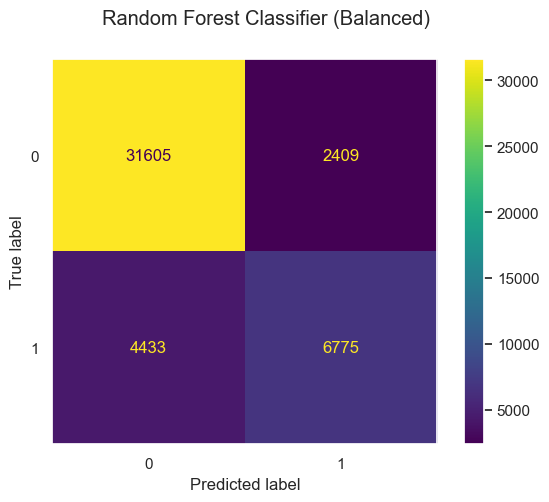

In [16]:
# confusion matrix and display 
conf_mat = confusion_matrix(y_true=y, y_pred=rf_y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))
conf_mat_disp.plot()
plt.suptitle('Random Forest Classifier (Balanced)')
plt.gcf().set_size_inches(7, 5)
plt.grid(False)

# Decision Tree Classifier

In [17]:
# initialize decision tree classifier
dec_tree_clf = DecisionTreeClassifier(max_depth=10,
                                      max_features = 'sqrt',
                                      min_samples_leaf = 2, min_samples_split = 2)

# initialize stratified kfold
skfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=27)

# cross validate
dt_y_pred = copy(y)
for train_idx, test_idx in skfold.split(X, y):
    x_train = X[train_idx, :]
    y_train = y[train_idx]
    
    x_test = X[test_idx, :]
    
    dec_tree_clf.fit(x_train, y_train)
    
    dt_y_pred[test_idx] = dec_tree_clf.predict(x_test)

# compute accuracy 
accuracy_score(y_pred=dt_y_pred, y_true=y)

dt_acc, dt_sens, dt_spec = get_acc_sens_spec(y_true=y, y_pred=dt_y_pred)
print('Accuracy:', dt_acc, 
      '\nSensitivity:', dt_sens, 
      '\nSpecificity:', dt_spec)

Accuracy: 0.831 
Sensitivity: 0.496 
Specificity: 0.941


### DTC Hyperparamater Tuning

In [18]:
# the paramaters we are looking at
param_dist = {
    'max_depth': [5, 15, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Create RandomizedSearchCV object
rand_search = RandomizedSearchCV(estimator=dec_tree_clf,
                                 param_distributions=param_dist,
                                 cv=5,
                                 n_iter=5,
                                 random_state=39)

# Fit RandomizedSearchCV object to data
rand_search.fit(X, y)

# Print best hyperparameters and corresponding score
best_param = rand_search.best_params_
print(rand_search.best_params_)
print(rand_search.best_score_)

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30}
0.8380215243992334


### DTC Tree Plot

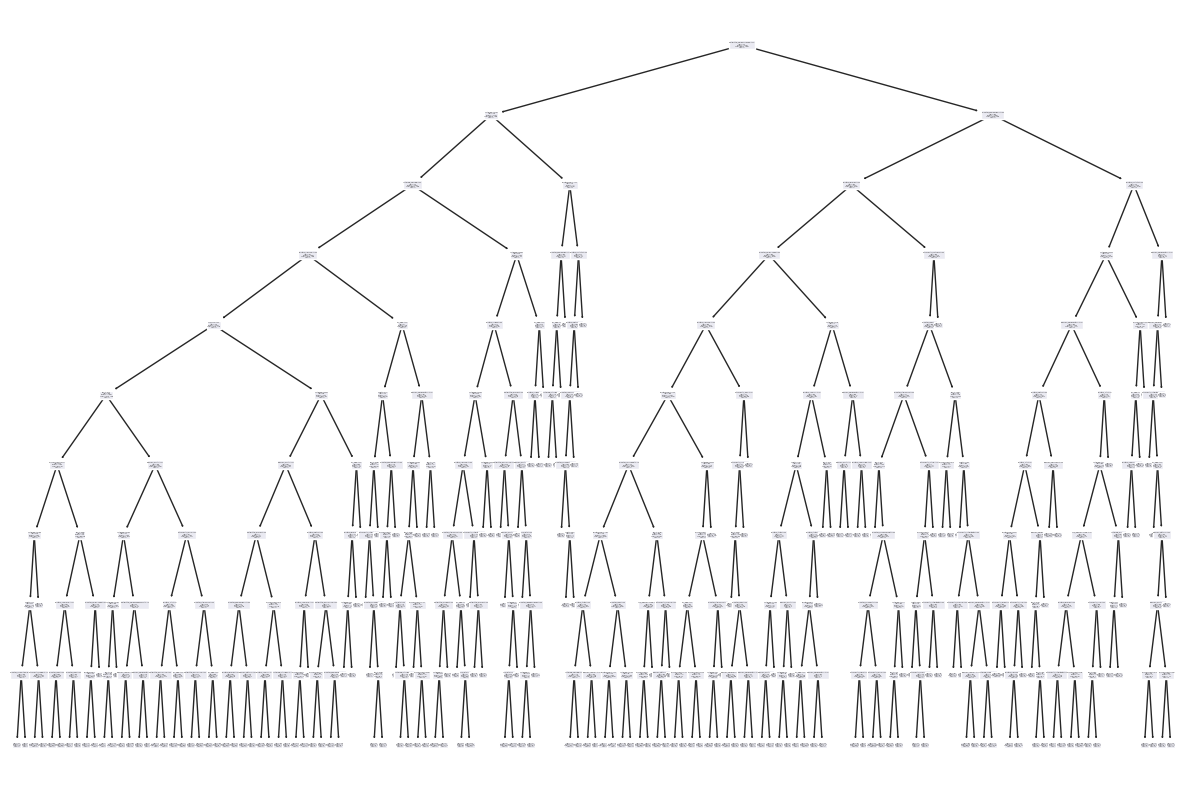

In [19]:
# initialize empty figure (plot_tree sets text size to fill given figure
# if we resize figure afterwards text size remains too small)
plt.figure()
#plt.figure(figsize=(10,6))
plt.gcf().set_size_inches(15, 10)
        
# 'plot' decision tree
plot_tree(dec_tree_clf, feature_names=x_feat_list, class_names=y_target);


### Hyper Tuned DTC

In [20]:
# initialize decision tree classifier
dec_tree_clf = DecisionTreeClassifier(max_depth=best_param['max_depth'],
                                      max_features = best_param['max_features'],
                                      min_samples_leaf = best_param['min_samples_leaf'], 
                                      min_samples_split = best_param['min_samples_split'])

# initialize stratified kfold
skfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=27)

# cross validate
dt_y_pred = copy(y)
for train_idx, test_idx in skfold.split(X, y):
    x_train = X[train_idx, :]
    y_train = y[train_idx]
    
    x_test = X[test_idx, :]
    
    dec_tree_clf.fit(x_train, y_train)
    
    dt_y_pred[test_idx] = dec_tree_clf.predict(x_test)

# compute accuracy 
accuracy_score(y_pred=dt_y_pred, y_true=y)

dt_acc, dt_sens, dt_spec = get_acc_sens_spec(y_true=y, y_pred=dt_y_pred)
print('Accuracy:', dt_acc, 
      '\nSensitivity:', dt_sens, 
      '\nSpecificity:', dt_spec)

Accuracy: 0.839 
Sensitivity: 0.577 
Specificity: 0.926


### DTC Classification Report

In [21]:
# display classification report
print(classification_report(y_pred=dt_y_pred, y_true=y))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     34014
           1       0.72      0.58      0.64     11208

    accuracy                           0.84     45222
   macro avg       0.79      0.75      0.77     45222
weighted avg       0.83      0.84      0.83     45222



### DTC Confusion Matrix

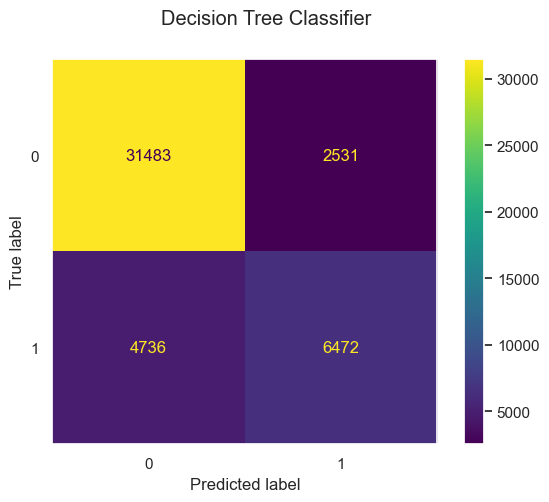

In [22]:
# confusion matrix and display 
conf_mat = confusion_matrix(y_true=y, y_pred=dt_y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))
conf_mat_disp.plot()
plt.suptitle('Decision Tree Classifier')
plt.gcf().set_size_inches(7, 5)
plt.grid(False)

# K-NN Classifier

In [23]:
# initialize k-nn classifier
knn_clf = KNeighborsClassifier(n_neighbors=10,
                               weights = 'uniform',
                              p=True)

# initialize stratified kfold
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)

# cross validate
knn_y_pred = copy(y)
for train_idx, test_idx in skfold.split(X, y):
    x_train = X[train_idx, :]
    y_train = y[train_idx]
    
    x_test = X[test_idx, :]
    
    knn_clf.fit(x_train, y_train)
    
    knn_y_pred[test_idx] = knn_clf.predict(x_test)

# compute accuracy 
accuracy_score(y_pred=knn_y_pred, y_true=y)

knn_acc, knn_sens, knn_spec = get_acc_sens_spec(y_true=y, y_pred=knn_y_pred)
print('Accuracy:', knn_acc, 
      '\nSensitivity:', knn_sens, 
      '\nSpecificity:', knn_spec)

Accuracy: 0.836 
Sensitivity: 0.549 
Specificity: 0.93


### KNN Hyperparamater Tuning

In [24]:
# the paramaters we are looking at
param_dist = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create RandomizedSearchCV object
rand_search = RandomizedSearchCV(estimator=knn_clf,
                                 param_distributions=param_dist,
                                 cv=5,
                                 n_iter=5,
                                 random_state=32)

# Fit RandomizedSearchCV object to data
rand_search.fit(X, y)

# Print best hyperparameters and corresponding score
best_param = rand_search.best_params_
print(rand_search.best_params_)
print(rand_search.best_score_)

{'weights': 'uniform', 'p': 2, 'n_neighbors': 10}
0.8370705737125957


### Hyper Tuned K-NN

In [25]:
# initialize k-nn classifier
knn_clf = KNeighborsClassifier(n_neighbors=best_param['n_neighbors'],
                               weights=best_param['weights'],
                               p=best_param['p'])

# initialize stratified kfold
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)

# cross validate
knn_y_pred = copy(y)
for train_idx, test_idx in skfold.split(X, y):
    x_train = X[train_idx, :]
    y_train = y[train_idx]
    
    x_test = X[test_idx, :]
    
    knn_clf.fit(x_train, y_train)
    
    knn_y_pred[test_idx] = knn_clf.predict(x_test)

# compute accuracy 
accuracy_score(y_pred=knn_y_pred, y_true=y)

knn_acc, knn_sens, knn_spec = get_acc_sens_spec(y_true=y, y_pred=knn_y_pred)
print('Accuracy:', knn_acc, 
      '\nSensitivity:', knn_sens, 
      '\nSpecificity:', knn_spec)

Accuracy: 0.838 
Sensitivity: 0.56 
Specificity: 0.929


### KNN Classification Report

In [26]:
# display classification report
print(classification_report(y_pred=knn_y_pred, y_true=y))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     34014
           1       0.72      0.56      0.63     11208

    accuracy                           0.84     45222
   macro avg       0.79      0.74      0.76     45222
weighted avg       0.83      0.84      0.83     45222



### KNN Confusion Matrix

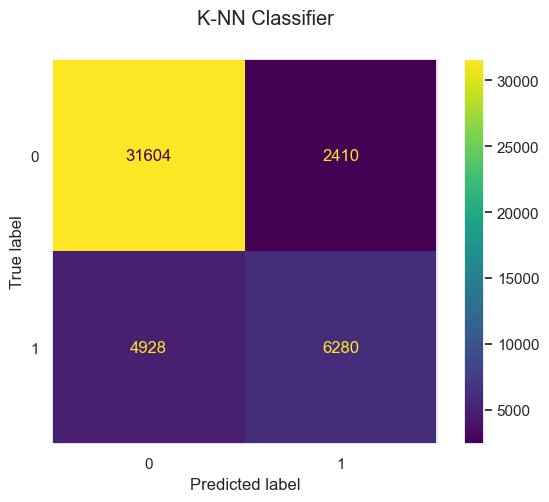

In [27]:
# confusion matrix and display 
conf_mat = confusion_matrix(y_true=y, y_pred=knn_y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))
conf_mat_disp.plot()
plt.suptitle('K-NN Classifier')
plt.gcf().set_size_inches(7, 5)
plt.grid(False)

# Results

### RFC, DTC, and KNN Accuracy, Sensitivity, and Specificity

In [28]:
performance = [['Random Forest Classifier', rf_acc, rf_sens, rf_spec],
                ['Decision Tree Classifier', dt_acc, dt_sens, dt_spec],
                ['K-NN Classifier', knn_acc, knn_sens, knn_spec]]
performance_df = pd.DataFrame(performance, columns=[' ', 'accuracy', 'sensitivity', 'specificity']).set_index(' ')
print(performance_df)

                          accuracy  sensitivity  specificity
                                                            
Random Forest Classifier     0.849        0.604        0.929
Decision Tree Classifier     0.839        0.577        0.926
K-NN Classifier              0.838        0.560        0.929


### RFC Feature Importance

In [29]:
# feature importance
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[-limit:]
        feat_import = feat_import[-limit:]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(10,5)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')
    print(feat_list[-limit:])


['capital-gain', 'hours-per-week', 'marital-status_Married-civ-spouse', 'fnlwgt', 'age']


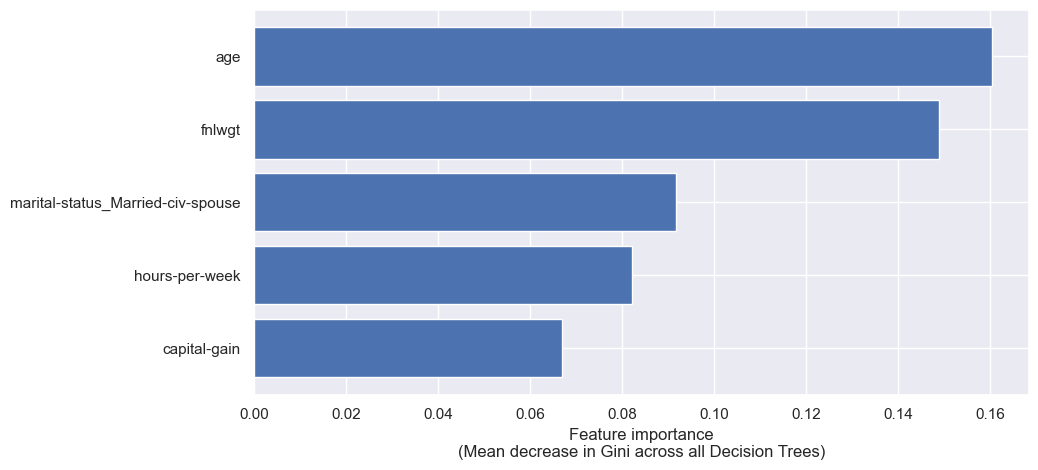

In [30]:
plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit=5)

### Top Features vs. Target Variable Correlation

In [31]:
# compute correlations
top_feat = ['capital-gain', 'marital-status_Married-civ-spouse', 
            'hours-per-week', 'age', 'fnlwgt']
corr_df = census_df[top_feat+[y_target]].corr()

# display results
print(corr_df.sort_values(y_target, axis=1).iloc[:, -1])

capital-gain                         0.221034
marital-status_Married-civ-spouse    0.446192
hours-per-week                       0.227199
age                                  0.237040
fnlwgt                              -0.007264
income_>50K                          1.000000
Name: income_>50K, dtype: float64


In [ ]:
## Dataset: https://www.kaggle.com/datasets/vivamoto/us-adult-income-update?resource=download